# nuclei spotter

#### libs


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *

In [3]:
import matplotlib.pyplot as plt
from tqdm import tqdm

### look at the data

In [4]:
path = Path('/home/ubuntu/data/fastai/data/nuclei'); 
trn_path = path/'stage1_train'
path.ls()[:5]

[PosixPath('/home/ubuntu/data/fastai/data/nuclei/label'),
 PosixPath('/home/ubuntu/data/fastai/data/nuclei/stage1_train_labels.csv'),
 PosixPath('/home/ubuntu/data/fastai/data/nuclei/stage1_solution.csv'),
 PosixPath('/home/ubuntu/data/fastai/data/nuclei/test.png'),
 PosixPath('/home/ubuntu/data/fastai/data/nuclei/stage1_test')]

In [5]:
stage1_train_labels = pd.read_csv(path/'stage1_train_labels.csv'); stage1_train_labels.head(2)

,ImageId,EncodedPixels
0,00071198d059ba7f5914a526d124d28e6d010c92466da2...,6908 1 7161 8 7417 8 7672 9 7928 9 8184 9 8440...
1,00071198d059ba7f5914a526d124d28e6d010c92466da2...,36269 7 36523 11 36778 13 37033 15 37288 17 37...


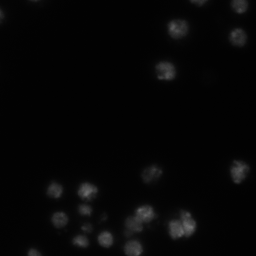

In [6]:
imgId, pixels = stage1_train_labels.iloc[0]
imgPath = path/f'stage1_train/{imgId}/images/{imgId}.png'
open_image(imgPath)

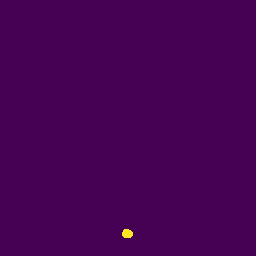

In [7]:
maskPath = path/f'stage1_train/{imgId}/masks'
open_mask(maskPath.ls()[0])

### concatenate masks into 1 file per image

1x image --> 1y mask

In [8]:
def image2np(path):
    x = plt.imread(str(path))
    a = np.asarray(x)
    return a.astype(np.float32, copy=False)
    
def combineMasks(imagePath):
    imgId = imagePath.stem
    imgPath = imagePath/f'images/{imgId}.png'
    imgSize = image2np(imgPath).shape
    all_masks = np.zeros(imgSize[:2])
    masksPath = imagePath.parent/f'{imgId}/masks'

    # add masks to one into 1 image
    for mask in masksPath.ls():
        currMask = image2np(mask)
#         currMask = np.expand_dims(currMask)

        all_masks = np.maximum(all_masks, currMask )
    return all_masks

In [9]:
img_fnames = [ img/f'images/{img.stem}.png' for img in trn_path.ls()]
img_folders = trn_path.ls()

In [10]:
curr_masks = [ [ mask for mask in (folder/'masks').ls()] for folder in img_folders ]

In [11]:
all_masks = reduce((lambda x,y: x + y), curr_masks)

In [12]:
np.amax(image2np(all_masks[0]))

1.0

In [13]:
combineMasks(img_folders[0])

array([[0., 0., 0., 0., ..., 0., 0., 0., 0.],
       [0., 0., 0., 0., ..., 0., 0., 0., 0.],
       [0., 0., 0., 0., ..., 0., 0., 0., 0.],
       [0., 0., 0., 0., ..., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., ..., 1., 1., 1., 1.],
       [0., 0., 0., 0., ..., 1., 1., 1., 1.],
       [0., 0., 0., 0., ..., 1., 1., 1., 1.],
       [0., 0., 0., 0., ..., 1., 1., 1., 1.]])

## move the images to a different folder

put all images at in base level folder 
images
all masks in label folder called labels

In [14]:
def saveArray(path, m):
    pil_image = PIL.Image.fromarray(m).convert("L")
    pil_image.save(path)

In [15]:
train_path = path/'train'
label_path = path/'label'

In [16]:
# copy all images to path/train
for img in tqdm(img_folders):
    imgPath = str(img/f'images/{img.stem}.png')
    newImgPath = str(train_path/f'{img.stem}.png')
#     print(imgPath)
#     print('--> ',newImgPath)
    if not (train_path/f'{img.stem}.png').is_file():
        !cp {imgPath} {newImgPath} 
    
    

100%|██████████| 670/670 [00:00<00:00, 21094.31it/s]


In [17]:
combined_masks = [{ 'name': img.stem,  'mask': combineMasks(img)} for img in img_folders];

In [16]:
# combine then copy all the masks to the train folder
for mask in combined_masks:
    
    maskPath = label_path/f'{mask["name"]}_mask.png'
    if not maskPath.is_file():
        saveArray(str(maskPath),mask["mask"])

NameError: name 'combined_masks' is not defined

In [17]:
new_masks = [ mask for mask in label_path.ls()]

In [18]:
mr = PIL.Image.open(str(new_masks[3]))
np.asarray(mr)

array([[0, 0, 0, 0, ..., 0, 0, 0, 0],
       [0, 0, 0, 0, ..., 0, 0, 0, 0],
       [0, 0, 0, 0, ..., 0, 0, 0, 0],
       [0, 0, 0, 0, ..., 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, ..., 0, 0, 0, 0],
       [0, 0, 0, 0, ..., 0, 0, 0, 0],
       [0, 0, 0, 0, ..., 0, 0, 0, 0],
       [0, 0, 0, 0, ..., 0, 0, 0, 0]], dtype=uint8)

In [19]:
image_shapes = [ x["mask"].shape[0] for x in combined_masks]
np.amin(image_shapes)

NameError: name 'combined_masks' is not defined

## Now make a databunch!

In [20]:
classes = np.array(["background", "nucleus"], dtype=str); classes

array(['background', 'nucleus'], dtype='<U10')

In [21]:
lng = len(train_path.ls())
valid_pct = int(lng*0.2)
valid_idx = list(range(lng))[:valid_pct]

get_y_fn = lambda x: label_path/f'{x.stem}_mask{x.suffix}'

In [22]:
src = (SegmentationItemList.from_folder(train_path) 
       .split_by_idx(valid_idx)
       .label_from_func(get_y_fn, classes=classes))

In [23]:
tfms = get_transforms(do_flip=True, 
                      flip_vert=False, 
                      max_rotate=10., 
                      max_zoom=1.1, 
                      max_lighting=0.2, 
                      max_warp=0., 
                      p_affine=0.75, 
                      p_lighting=0.75)
# tfms = get_transforms()

In [24]:
data64 = (src.transform(tfms, tfm_y=True, size=64)
       .databunch(bs=64))
# data = src.databunch()

In [25]:
data64.train_ds[4][1].data

tensor([[[1, 0, 0,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 1, 1, 1],
         ...,
         [0, 1, 1,  ..., 0, 0, 0],
         [0, 0, 1,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]])

# The model and learner!

In [26]:
torch.cuda.is_available()

True

In [29]:
wd=1e-2

In [30]:
learn = unet_learner(data64, models.resnet34, wd=wd)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


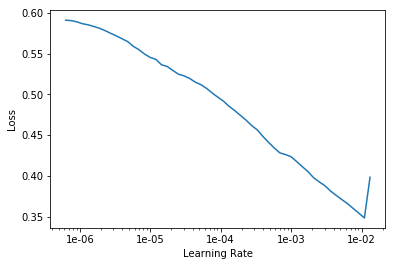

In [31]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(6, 1e-3)

epoch,train_loss,valid_loss,time
0,0.427216,0.371344,00:08
1,0.366221,0.296592,00:06
2,0.299147,0.222078,00:05
3,0.252289,0.144840,00:05
4,0.219477,0.136526,00:05
